<h1 style="font-size:300%">EXPERT CHAT</h1>

This notebook is a demonstration of using [PyTorch Lightning](https://lightning.ai/pytorch-lightning) and transfer learning to fine tune a pretrained large language model using Parameter-Efficient Fine-Tuning (PEFT) training a Low-Rank Adaptation (LoRA). The idea here is that the LoRA will help the model to be able to speak sensibly about board games. A data set on board game information is included in the git repo, so you can just clone this repo and run the notebook.

Bas S.H.T. Michielsen, 2026

![banner](https://raw.githubusercontent.com/bshtmichielsen/expert_chat/refs/heads/main/BANNER.jpg)

*Image by Stable Diffusion: a machine explaining board games to children*

In [1]:
import json, lightning, os, pandas, pathlib, peft, platform, torch, transformers

from torch.utils.data import Dataset, DataLoader
from lightning import LightningModule, LightningDataModule, Trainer
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import EarlyStopping
from transformers import AutoModelForCausalLM, AutoTokenizer

torch.set_float32_matmul_precision('high') # For Cuda Tensor Cores

base_model_name = "gpt2-medium" # alternatively use "gpt2" for a smaller model, or "gpt2-large" for a larger model.
data_path = "data/board-game.jsonl"

print("Versions: python", platform.python_version(), "| torch", torch.__version__, "| lightning", lightning.__version__, "| transformers", transformers.__version__)

Versions: python 3.14.2 | torch 2.9.1+cu130 | lightning 2.6.0 | transformers 4.57.5


# Base model
We are not going to train a large language model from scratch, but rather use an existing model and make a small change to it. Here we load the base model, in this example GPT2, and prepare a tokenizer.

In [2]:
base_model = AutoModelForCausalLM.from_pretrained(base_model_name, dtype="auto", device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
tokenizer.pad_token = tokenizer.eos_token
print("Loaded a pretrained model of type", type(base_model))

Loaded a pretrained model of type <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'>


Given that large language models work with tokens and humans prefer strings of words, we define a reusable helper function to ask a response from a LLM model based on a prompt using the tokenizer. It converts the input prompt (a string) to tokens, asks the model for a response, and then returns the output tokens converted to a string that humans can read.

In [3]:
def get_response(model, tokenizer, prompt):
    inputs = tokenizer(prompt, return_tensors="pt", padding=True)
    input_ids = inputs["input_ids"].to(model.device)
    attention_mask = inputs["attention_mask"].to(model.device)
    output = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        max_new_tokens=100,
        do_sample=True,
        temperature=0.7,
        top_p=0.8,
        top_k=50,
        repetition_penalty=1.2,
        pad_token_id=tokenizer.eos_token_id,
    )
    text = tokenizer.decode(output[0], skip_special_tokens=True)
    return text[len(prompt):].lstrip()

Let's see if the helper function works and ask the base model a prompt that it will probably not do well on. In this case it produces a bit of non-sense and addresses our prompt to explain board game characteristics rather poorly.

In [4]:
prompt = "Explain some typical characteristics of a board game."
print(get_response(base_model, tokenizer, prompt))

, an action card in the set , which can be played at any time to change one or more characters on the table (see below). A player must choose between playing cards from their hand and those they have drawn during that turn; if either choice is made, then players may discard them after this step ends. For example: If you play 1 copy each for both your character's abilities and two copies of his skill power , he gains +2 attack when attacking with him while holding up 2


# Load the data set
Here we load the data set with the text about board games. The text is stored in sets of `prompt` and `completion` elements, where the idea is that the model learns what kind of responses are correct for what kind of prompts. By default LLMs return the given prompt as the start of the response. Given that we wish to train some Q&A type model, the question text should not be used for loss calculations (repeating the question does not make the answer better or worse). To this end we indicate the prompt text as irrelevant for loss calculation by marking its tokens with `-100`.

In [5]:
class JsonlDataset(Dataset):
    def __init__(self, file_path, tokenizer, max_len=256):
        self.samples = []
        self.tokenizer = tokenizer
        self.max_len = max_len
        with pathlib.Path(file_path).open() as f:
            for line in f:
                obj = json.loads(line)
                self.samples.append((obj["prompt"], obj["completion"]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        prompt, completion = self.samples[idx]
        tokenized = self.tokenizer(prompt + completion, truncation=True, max_length=self.max_len)
        input_ids = torch.tensor(tokenized["input_ids"])
        attention_mask = torch.tensor(tokenized["attention_mask"])
        labels = input_ids.clone()
        prompt_len = len(self.tokenizer(prompt, add_special_tokens=False)["input_ids"])
        labels[:prompt_len] = -100 # For every prompt token set the label to -100, so it is not used in loss calculation.
        return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}
  
dataset = JsonlDataset(data_path, tokenizer)
print("Created a dataset with", len(dataset), "samples")

Created a dataset with 702 samples


# Observe the data
Let's print a single data item and look at the results. It contains a collection of input_ids which refer to tokens, an attention mask, and labels. Note that the labels are equal to the input_ids except for those token that belong to the prompt (at the start of the collection).

In [6]:
data_item = dataset[0]
data_item

{'input_ids': tensor([24564,  4892,   262,  4096,  9432,   286,   749,  3660,  3096,  1830,
            13,  6943,  3660,  3096,  1830,  1265,  1938,   284,  4620,   257,
          1598,  5373,  4006,   884,   355,  8978,   257,  2496,  4776,    11,
         14339,   257,   900,   286, 15221,    11,   852,   262,   938,  2137,
          5637,    11,   393, 26187,   257,   606,  1512,  3061,   357,    68,
            13,    70,  1539,  2615,   257,  9443,    11, 14339, 11926,    11,
           393, 21320,  7691,   737,  3776,  1759,  6032,  3983,   689,  4962,
            11,   290,  1938,   779,  4811,    11,  8271,  4542,    11,  8458,
            11,   393, 24462,   284,  4371,  3812,   326,  9432,    13]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1,

In [7]:
prompt = [token for token, label in zip(data_item["input_ids"], data_item["labels"]) if label == -100] 
completion = [token for token, label in zip(data_item["input_ids"], data_item["labels"]) if label > -100] 

print(tokenizer.decode(prompt))
print("----")
print(tokenizer.decode(completion))

Describe the basic objective of most modern board games.
----
Most modern board games ask players to achieve a clear victory condition such as reaching a target score, completing a set of objectives, being the last player remaining, or fulfilling a thematic goal (e.g., building a settlement, completing routes, or defeating opponents). Gameplay typically alternates turns, and players use strategy, resource management, luck, or negotiation to progress toward that objective.


# Splitting the data set using Data Loaders
We define two data loaders, one for training and one for validation. This example notebook does not involve a testing phase, so training and validation are all we need here. The collate function ensures that all items in a batch are of equal length by padding them with pad tokens. Additionally, for each pad token it sets the attention mask to 0 and its label to -100 (meaning irrelevant).

In [8]:
def collate(batch):
    input_ids = [b["input_ids"] for b in batch]
    attention_mask = [b["attention_mask"] for b in batch]
    labels = [b["labels"] for b in batch]
    input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask = torch.nn.utils.rnn.pad_sequence(attention_mask, batch_first=True, padding_value=0)
    labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=-100)
    return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

class TextDataModule(LightningDataModule):    
    def __init__(self, data, split=[.8, .2], batch_size=4, num_workers=0):
        super().__init__()
        self.data = data
        self.split = split
        self.batch_size = batch_size
        self.num_workers = num_workers

    def setup(self, stage=None):
        torch.manual_seed(42)
        self.train, self.val = torch.utils.data.random_split(self.data, self.split)

    def train_dataloader(self):
        return DataLoader(self.train, collate_fn=collate, shuffle=True, batch_size=self.batch_size, num_workers=self.num_workers)
    
    def val_dataloader(self):
        return DataLoader(self.val, collate_fn=collate, batch_size=self.batch_size, num_workers=self.num_workers)

datamodule = TextDataModule(dataset)

# Defining the model
Our model will be a combination of the pre-loaded base model, with an additional LoRA to manipulate the final output. The base model will not be retrained and thus remains frozen, however we wrap a PEFT model around it with a LoRA configuration. This happens in two steps, first the base model is prepared training using peft and then the LoRA config is injected. If we now train this LightningModule it will train the LoRA only.

In [9]:
class LoRA(LightningModule):
    def __init__(self, base_model, learning_rate=5e-5, weight_decay=0.01, warmup_steps=200):
        super().__init__()
        self.save_hyperparameters(ignore=["base_model"])
        model = peft.prepare_model_for_kbit_training(base_model)
        lora_cfg = peft.LoraConfig(
            r=32,
            lora_alpha=64,
            target_modules=["c_attn", "c_proj"],  # For GPT‑style models
            lora_dropout=0.05,
            bias="none",
            fan_in_fan_out=True,
        )
        self.model = peft.get_peft_model(model, lora_cfg)

    def forward(self, **batch):
        return self.model(**batch)

    def training_step(self, batch, batch_idx):
        outputs = self(**batch)
        return outputs.loss
    
    def validation_step(self, batch, batch_idx):
        outputs = self(**batch)
        val_loss = outputs.loss
        self.log("val_loss", val_loss, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.hparams.learning_rate, weight_decay=self.hparams.weight_decay)
        scheduler = transformers.get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=self.hparams.warmup_steps, num_training_steps=self.trainer.estimated_stepping_batches)
        return {"optimizer": optimizer, "lr_scheduler": {"scheduler": scheduler, "interval": "step"}}

lora = LoRA(base_model)

# Training
Here we use the pytoch lightning Trainer to fit the model (in reality the internal LoRA) with the provided datamodule.

In [10]:
logger = CSVLogger(save_dir=".")
stop = EarlyStopping(monitor="val_loss", mode="min", patience=3)
trainer = Trainer(max_epochs=-1, logger=logger, callbacks=[stop])
trainer.fit(lora, datamodule=datamodule)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params | Mode  | FLOPs
----------------------------------------------------
0 | model | PeftModel | 363 M  | train | 0    
----------------------------------------------------
8.7 M     Trainable params
354 M     Non-trainable params
363 M     Total params
1,453.896 Total estimated model params size (MB)
722       Modules in train mode
320       Modules in eval mode
0         Total Flops


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Bas\AppData\Local\Programs\Python\Python314\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.
c:\Users\Bas\AppData\Local\Programs\Python\Python314\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\Bas\AppData\Local\Programs\Python\Python314\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:534: Found 320 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If th

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

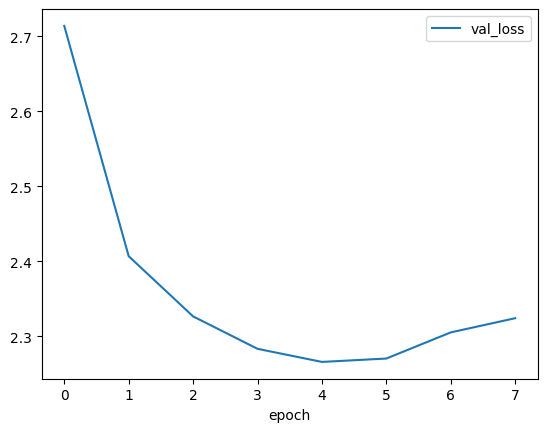

In [11]:
metrics = pandas.read_csv(os.path.join(trainer.log_dir, "metrics.csv"))
loss_metrics = metrics[["epoch", "val_loss"]].set_index("epoch")
plot = loss_metrics.plot()

# Inference

Here we manually observe the LoRA output to see if its responses now make more sense. Note that this is a human interpretation, however, given that the goal is to have a casual chat about board games, the apparent quality seems to have improved.

In [12]:
prompt = "Explain some typical characteristics of a board game."
print(get_response(lora.model, tokenizer, prompt))

A boardgame requires complex rules, strategic depth (elements, resources), inter-connected strategies and player decision making to achieve balanced play through design principles such as balance between resource acquisition/management , planning & execution within the board games process this balancing act that creates immersive experiences for players throughout their journey in managing strategy across multiple gameplay paths.[2]Boardgames often incorporate elements like dice rolls or card shuffling to facilitate these interactions, allowing designers create meaningful choices with each board session by providing additional opportunities where


In [13]:
prompt = "What are common componenents of board games?"
print(get_response(lora.model, tokenizer, prompt))

Common components include tiles, cards or tokens to track progress and provide predictability in the board game. They can be used as markers for milestones like reaching a certain goal (such



In [14]:
prompt = "Do board games involve strategies?"
print(get_response(lora.model, tokenizer, prompt))

Board game strategy involves planning, negotiating, and timing actions to achieve optimal outcomes. Strategic prioritization helps predict opponent moves or position changes before opponents realize their full potential through coordinated action-reaction cycles of positioning advantage development in the boardgame world (Brenner et al., 2013).Planning opportunities for breakthroughs requires flexible interactions between players that create strategic momentum, while managing risk minimizes uncertainty and pressure points within a board game system.*Mechanics of planning include coordinating resources, optimizing time,
